In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import toml 
import os

from src.models import get_ASTROMER_II
from src.data import load_data
from matplotlib import gridspec

%load_ext autoreload
%autoreload 2

2023-07-18 17:10:57.894777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [51]:
WEIGTHS = './presentation/experiments/astromer_2/results/nsp_normal/2_4_64_rmse_0.5/pretraining/'
with open(os.path.join(WEIGTHS, 'config.toml'), 'r') as f:
    model_config = toml.load(f)
    
model_config['pe_dim'] = 128

In [52]:
astromer = get_ASTROMER_II(num_layers=model_config['layers'],
                           num_heads=model_config['nh'],
                           head_dim=model_config['hdim'],
                           mixer_size=model_config['mixer'],
                           dropout=model_config['dropout'],
                           pe_base=1000,
                           pe_dim=model_config['pe_dim'],
                           pe_c=1,
                           window_size=model_config['ws'],
                           encoder_mode=model_config['encoder_mode'])
astromer.load_weights(os.path.join(WEIGTHS, 'weights')).expect_partial()

PE_C RECEIVED:  tf.Tensor(1.0, shape=(), dtype=float32)


In [53]:
batches = load_data(dataset=os.path.join('./data/records/macho_clean/', 'val'), 
                    batch_size=32, 
                    probed=1,#model_config['probed'],  
                    window_size=model_config['ws'], 
                    nsp_prob=0,#model_config['nsp_prob'], 
                    repeat=1, 
                    sampling=False,
                    test_mode=True)

In [54]:
for x, y in batches.take(1):
    y_cls, y_pred = astromer(x)
    y_mask = y['probed_mask']
    y_true_cls = y['nsp_label']
    y_true = y['magnitudes']
    times = x['times'][:, 1:, :]  
    x_original = x['original']

Text(0.96, 0.5, 'Predicted Magnitude')

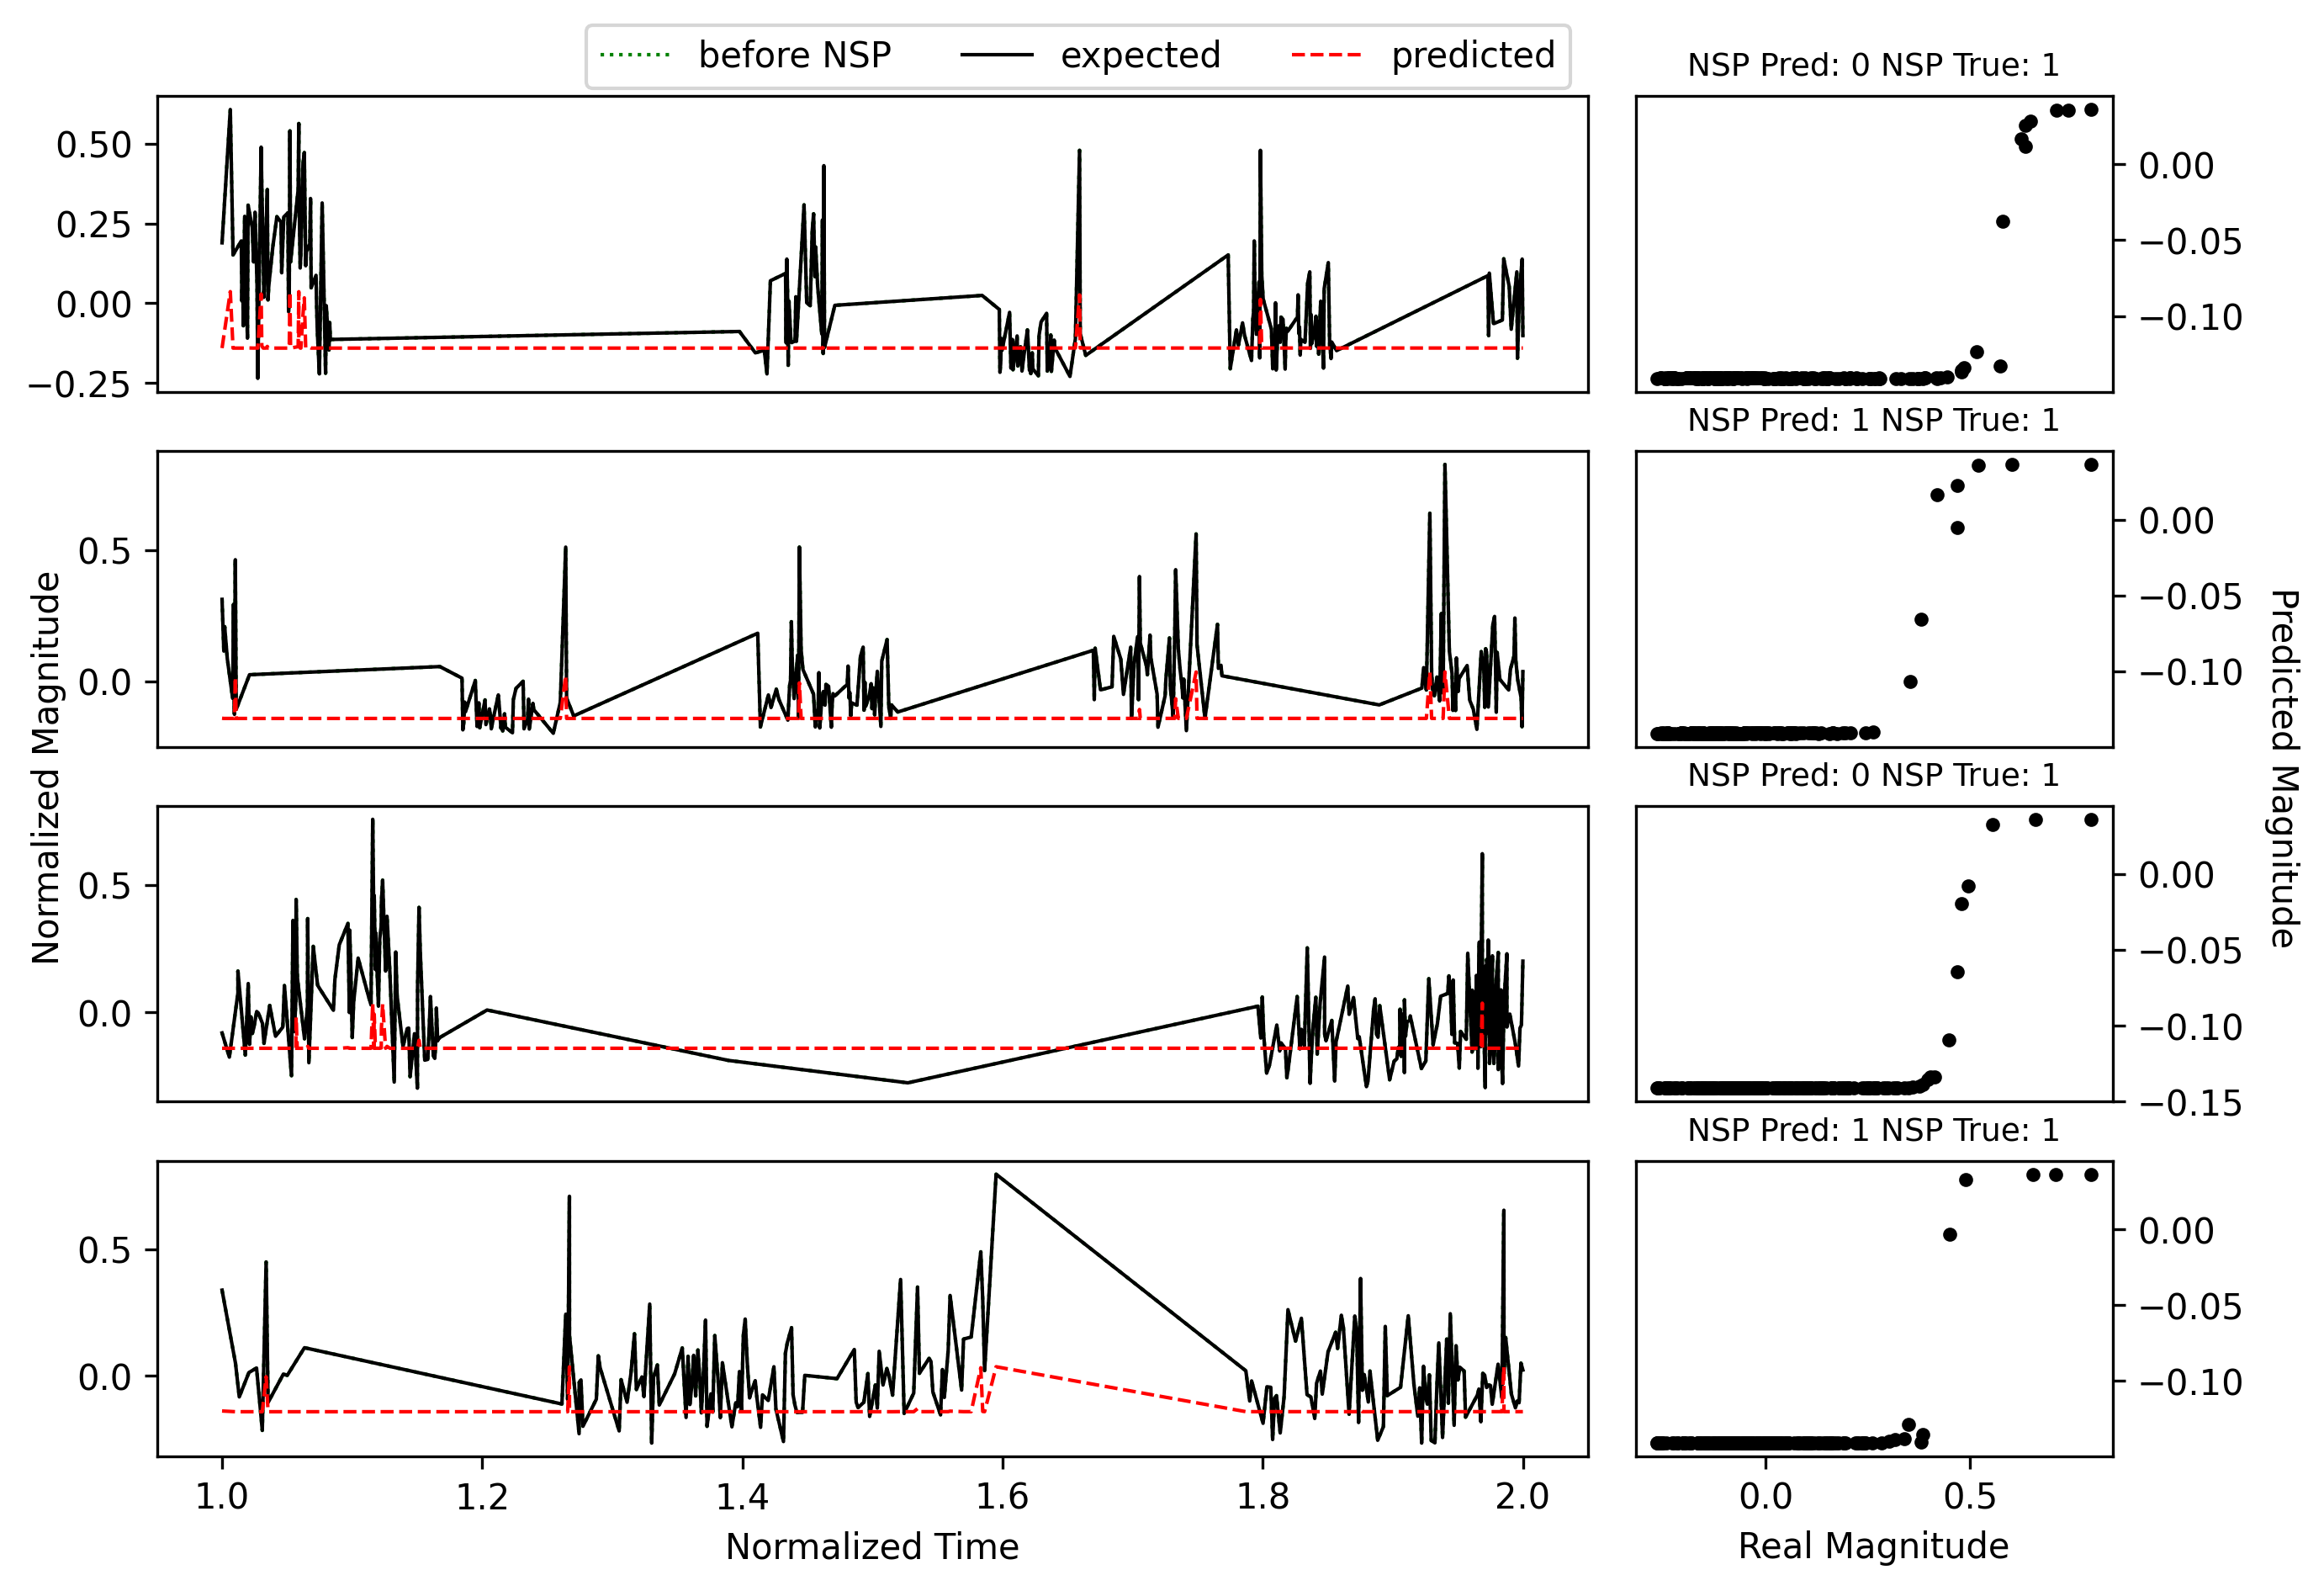

In [56]:
N = 4
                  
fig = plt.figure(figsize=(10,7), dpi=300)
gs = gridspec.GridSpec(N, 2, width_ratios=[3, 1]) 
plt.subplots_adjust(hspace=0.2, wspace=0.05)
for i, x, y, m, t, nsppred, nsptrue, xo in zip(range(N), y_true, y_pred, 
                                               y_mask, times, y_cls, 
                                               y_true_cls, x_original):
    ax0 = plt.subplot(gs[i, 0])
    ax1 = plt.subplot(gs[i, 1])
            
    probed_pred  = tf.boolean_mask(y, m)
    probed_true  = tf.boolean_mask(x, m)
    probed_time  = tf.boolean_mask(t, m)
    original_seq = tf.boolean_mask(xo[:, 1, None], m)
    
    ax0.plot(probed_time, original_seq, marker='', linewidth=1, linestyle=':', color='g', label='before NSP')
    ax0.plot(probed_time, probed_true, marker='', linewidth=1, linestyle='-', color='k', label='expected')
    ax0.plot(probed_time, probed_pred, marker='', linewidth=1, linestyle='--', color='r', label='predicted')

    ax1.plot(probed_true, probed_pred, '.', color='k')
    if i< N-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax1.set_xticks([])
        
    ax1.yaxis.tick_right() 
    nsp_predicted = tf.argmax(nsppred, 1).numpy()[0]
    nsp_real = int(nsptrue.numpy()[0])

    ax1.set_title('NSP Pred: {} NSP True: {}'.format(nsp_predicted, nsp_real), fontsize=9)
    
    if i ==0:
        ax0.legend(ncol=3,bbox_to_anchor=(1, 1.3))
        
ax0.set_xlabel('Normalized Time')

ax1.set_xlabel('Real Magnitude')
fig.text(0.075, 0.5, 'Normalized Magnitude', va='center', rotation='vertical')
fig.text(0.96, 0.5, 'Predicted Magnitude', va='center', rotation=-90)